# Compétition data : Prediction de l'importance des maladies chroniques à moyen-terme pour les établissements de santé


In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## À propos de cette compétition

* Organisateurs : ANAP et ATIH (institutions de santé)
* Objectif : Prédie l'importance à moyen-termes des dépenses liées aux maladies chroniques
* Type de problème : Régression (cible comprise entre 0 et 1, pas d'explication sur ce qu'elle représente exactement)
* Métrique : [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)
* Plateforme : [Datascience.net](https://www.datascience.net)
    * **600 participants**
    * **3 mois**, finie le 14/10/2016
    * Ceci détaille **ma solution, classée 9ème au classements privés et publics**

Plus de détails sur la compétition peuvent être trouvés sur la [page de la compétition](https://www.datascience.net/fr/challenge/28/details)

### Les données

1. Données d'entraînement et de test sur les logs des entrées (âge, année, établissement de santé, nombre de visites à d'autres établissements de santé)
    * Train : 1879842 lignes, 8 colonnes + cible, couvrant les **années 2008 à 2013**
    * Test : 664524 lignes, 8 colonnes, **années 2014 à 2015** 
2. Des informations sur chaque établissement issues des données hospidiags ([hospidiag](http://hospidiag.atih.sante.fr/cgi-bin/broker?_service=hospidiag&_debug=0&_program=hd.accueil_hd.sas) rapports)
3. Toute donnée disponible en open data : quelques essais à partir des données [data.gouv.fr](http://www.data.gouv.fr/fr/) mais rien de concluant ce qui s'explique principalement par un manque de granularité des données open data trouvées

La data était fournie en l'état, il y avait donc encore un travail de data engineering plus conséquent que dans une compétition kaggle classique. 

### Ce notebook

Ce notebook ne se veut pas un recueuil exhaustif de l'approche adoptée mais se veut d'avantage un résumé éclairé d'exemple de codes. Certains détails de l'implémentation technique et opérationnelle ne seront pas développés.
Pour le code complet, on pourra se référer notamment au [github](https://github.com/Iwontbecreative/chronic_disease_competition).

Sommaire des fichiers présents :

```
thibault@thibault:~/Code/chronic$ wc *.py
   25   108  1090 columns.py               : Colonnes à garder suite à la sélection
  172   595  6090 helper.py                : Helpers pour cross-validation, output en csv, transformer features, etc.
    0     0     0 __init__.py              : Transformer le dossier en package python
   45   136  1395 linear_second_level.py   : Script pour stacking par rég linéaire (pas utilisé dans toutes les versions)
   42   120  1175 mini_scaler.py           : Script pour scaler les csv servant au stacking
  178   619  6308 process.py               : Script principal de machine learning
   35    83   868 scaler.py                : Script pour scaler les csv d'outputs
  219   896  8365 transform_data.py        : Script pout transformer les données en format utilisable.
  716  2557 25291 total
```
On a donc **716 lignes de code**, la majorité étant du data engineering



### Approches historiques

Ce notebook contient essentiellement les détails de la dernière approche. Pour voir l'évolution des différentes approches et l'évolution du code, on pourra se référer à l'historique des versions du github.

## Pré-traitement des données : transform-data.py

### Les problèmes :

1. Noms de colonnes  trop longs/peu pratiques
2. Valeurs manquantes
3. Données de type mixte dans les colonnes (plus de ram nécessaire)
4. Données catégoriques
5. Merger les rapports hospidiag aux autres données

### Solutions classiques pour les problèmes 1 à 4

1. Colonnes renommées 
2. Remplacées par la valeur -1000 cf
    * les autres méthodes (en particulier remplacement par la moyenne pour les numériques et modepour catégorielles) ne donnaient pas de bons resultats
    * on utilise des méthodes d'arbres qui ne sont pas affectés par ce remplacement
3. On transforme les données textuelles en numériques au cas par cas (cf handle_uglyness)
4. On utilise LabelEncoder qui fonctionne mieux que de binariser les catégories en $n-1$ colonnes car
    * On a trop de catégories pour que cela soit tractable
    * Les approches de type arbre peuvent fitter les $n$ catégories encodées de $1$ à $n$
    
### Solutions pour le problème 5

Les données hospidiag ne font allusion qu'à un seul champ (établissement) mais ces données avaient un pouvoir prédictif plus grand parce que :
* La variable établissement a une influence sur la cible (à autres variables fixées)
* Il y a beaucoup d'établissements (~1350) donc peu de données par établissement. Par conséquent, un arbre va souvent overfitter ou underfitter du fait du manque de données. Remplacer l'établissement par le vecteur de ces caractéristiques permet aux méthodes d'arbres de pouvoir comparer les établissements et d'apprendre avec plus de données. On augmente ainsi la dimensionalité en remplacant le problème: $y = f(info\_sej, nom\_eta) + \epsilon $ par $y = f(info\_sej, info\_eta) + \epsilon $.

Remarque : L'intégration des données hospidiag était la principale source de variabilité sur le leaderboard et était une opération délicate.

##### Choix des variables à intégrer

On utilise pandas pour merger nos informations sur les établissements à celles sur les entrées.
On merge donc en fonction des variables nom_eta et year.

On a environ 195 colonnes sur les établissements. Si on merge cela directement, on se retrouve avec ~2M lignes * 200 colonnes. Par conséquent, on va avoir des fichiers .csv plus lourds que 4Go alors qu'on travaille avec 4Go de ram. On a donc utilisé trois méthodes pour réduire la quantité de données à traiter sans perdre d'information essentielle.


1. Intuition: On a pris toutes les colonnes qui étaient directement ou indirectement liées aux maladies chroniques. Pour ceci on a regardé le [descriptif fourni](https://www.datascience.net/fr/files/getFile?fileName=hospidiag.pdf&challengeId=28) de chaque variable. Des exemples de variables intégrées: 
     * P12: Taux de chirurgie ambulatoire pour l'établissement. 
        Les ALD (affections de longue durée $\approx$ maladies chroniques) exigeant des traitements classiques et connus avec des patients réguliers, la plupart ne restent pas plus d'un jour et sont donc classés en chirurgie ambulatoire. Un taux important de chirurgie ambulatoire signale donc un établissement qui traite beaucoup de maladies chroniques.
     * A5bis: Part de marché en cancérologie sur la région. 
        Certains types de cancer étant considérés comme chroniques, il est naturel que ce critère indique que le poids des maladies chroniques sera plus important dans l'établissement.

2. Random selection: On lance notre algorithme m fois avec n features et on sélectionne à chaque fois les o features les plus importantes. Pour cela, on a utilisé un RandomForest et une cross-validation sur 2 subsets à 10 arbres pour pouvoir beaucoup itérer. Ceci nous donne une heuristique statistique des variables ayant les plus fortes contributions.

3. Greedy search: Une fois la liste de variable candidates sélectionnées, on utilise un algorithme de greedy search avec forward selection. On l'utilise pour sélectionner un subset de variables suite aux sélections effectuées avec 1. et 2.
    
##### Choix des lignes à prédire/intégrer dans le modèle

Les différentes visualisations des données montrent que dans 100% des cas: $ nombre\_sej\_ald = 0 \implies cible = 0 $.
Il ne s'agit pas ici d'overfitting, il est naturel que le coût des maladies chroniques soit nul pour un patient si il n'a pas de séjour pour maladies chroniques.
Par conséquent, on passe de 1879k à 859k lignes de train et de 664k à 317k lignes de test.

### Visualisation

In [11]:
import pandas as pd
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 200)
print("Avant l'ajout des colonnes liées à l'établissement et autres modifs.")
old = pd.read_csv('data2.csv', sep=';', low_memory=False)
print("Presque pas de NA dans le dataset, des données dans des formats peu exploitables.")
print("On a dans cible1 des données 0 prévisibles parfaitement et qui viennent perturber l'apprentissage des données > 0")
old.head(5)

Avant l'ajout des colonnes liées à l'établissement et autres modifs.
Presque pas de NA dans le dataset, des données dans des formats peu exploitables.
On a dans cible1 des données 0 prévisibles parfaitement et qui viennent perturber l'apprentissage des données > 0


,Finess,Raison sociale,Provenance des patients (département),Domaines d activités,"âge (deux classes >75 ans, <= 75 ans)",Nombre de séjours/séances MCO des patients en ALD,Nombre total de séjours/séances,annee,cible1
0,010007300,CLINIQUE AMBULATOIRE CENDANEG,01-Ain,D01-Digestif,<=75 ans,19,1061,2008,0.010624
1,010007300,CLINIQUE AMBULATOIRE CENDANEG,01-Ain,D01-Digestif,>75 ans,5,48,2008,0.053320
2,010007300,CLINIQUE AMBULATOIRE CENDANEG,01-Ain,D07-Cardio-vasculaire (hors cathétérismes vasc...,<=75 ans,0,1,2008,0.000000
3,010007300,CLINIQUE AMBULATOIRE CENDANEG,01-Ain,D16-Hématologie,<=75 ans,0,17,2008,0.000000
4,010007300,CLINIQUE AMBULATOIRE CENDANEG,01-Ain,D16-Hématologie,>75 ans,0,2,2008,0.000000


In [13]:
print("Après l'ajout")
new = pd.read_csv('proc_data.csv')
new.head(5)

Après l'ajout


,eta,nom_eta,prov_patient,dom_acti,age,nombre_sej_ald,nombre_sej,an,label,id,A12,A13,A14,A8,A9,CI_A1,CI_A12,CI_A15,CI_A16_1,CI_A16_2,CI_A16_3,CI_A16_4,CI_A16_5,CI_A16_6,CI_A18_1,CI_A2,CI_A4,CI_A5,CI_A7,CI_A8,CI_AC1,CI_AC4,CI_AC6,CI_AC7,CI_DF1,CI_DF2,CI_DF3,CI_DF4,CI_DF5,CI_E1,CI_E2,CI_E3,CI_E4,CI_E4_V2,CI_E5,CI_E6,CI_E7,CI_E7_V2,CI_RH1,CI_RH2,CI_RH3,CI_RH4,P1,P12,P13,P14,P15,P2,P9,RH2,RH3,RH4,RH5,RH6,cat,taille_C,taille_MCO,zone_pdmreg,A1bis,A2bis,A3bis,A4bis,A5bis,zone_pdmza,A1,A2,A3,A4,A5,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12
0,10007300,640,1,1,0,19,1061,2008,0.010624,0,-1000.0,-1000.0,-1000.0,0.0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,464,0.0,1301.0,1.0,0.0,0.0,-1000.0,-1000.0,-1000.0,2.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,1.0,-1000.0,-1000.0,-1000.0,1.8,0.4,-1000.0,1.4,-1000.0,100.0,100.0,0.2,-1000.0,-1000.0,108.0,0.0,-1000.0,-1000.0,-1000.0,-1000.0,3,1,1,82,-1000.0,0.2,-1000.0,-1000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,21.6,18.7,100.0,0.0,0.0,-1000.0,70.5,-1000.0,-36.4,127.5,14.9,29.5
1,10007300,640,1,1,1,5,48,2008,0.053320,1,-1000.0,-1000.0,-1000.0,0.0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,464,0.0,1301.0,1.0,0.0,0.0,-1000.0,-1000.0,-1000.0,2.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,1.0,-1000.0,-1000.0,-1000.0,1.8,0.4,-1000.0,1.4,-1000.0,100.0,100.0,0.2,-1000.0,-1000.0,108.0,0.0,-1000.0,-1000.0,-1000.0,-1000.0,3,1,1,82,-1000.0,0.2,-1000.0,-1000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,21.6,18.7,100.0,0.0,0.0,-1000.0,70.5,-1000.0,-36.4,127.5,14.9,29.5
2,10007300,640,1,26,0,2,25,2008,0.027969,7,-1000.0,-1000.0,-1000.0,0.0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,464,0.0,1301.0,1.0,0.0,0.0,-1000.0,-1000.0,-1000.0,2.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,1.0,-1000.0,-1000.0,-1000.0,1.8,0.4,-1000.0,1.4,-1000.0,100.0,100.0,0.2,-1000.0,-1000.0,108.0,0.0,-1000.0,-1000.0,-1000.0,-1000.0,3,1,1,82,-1000.0,0.2,-1000.0,-1000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,21.6,18.7,100.0,0.0,0.0,-1000.0,70.5,-1000.0,-36.4,127.5,14.9,29.5
3,10007300,640,39,1,0,1,13,2008,0.020652,10,-1000.0,-1000.0,-1000.0,0.0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,464,0.0,1301.0,1.0,0.0,0.0,-1000.0,-1000.0,-1000.0,2.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,1.0,-1000.0,-1000.0,-1000.0,1.8,0.4,-1000.0,1.4,-1000.0,100.0,100.0,0.2,-1000.0,-1000.0,108.0,0.0,-1000.0,-1000.0,-1000.0,-1000.0,3,1,1,82,-1000.0,0.2,-1000.0,-1000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,21.6,18.7,100.0,0.0,0.0,-1000.0,70.5,-1000.0,-36.4,127.5,14.9,29.5
4,10007300,640,74,1,0,2,100,2008,0.007627,15,-1000.0,-1000.0,-1000.0,0.0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,464,0.0,1301.0,1.0,0.0,0.0,-1000.0,-1000.0,-1000.0,2.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,1.0,-1000.0,-1000.0,-1000.0,1.8,0.4,-1000.0,1.4,-1000.0,100.0,100.0,0.2,-1000.0,-1000.0,108.0,0.0,-1000.0,-1000.0,-1000.0,-1000.0,3,1,1,82,-1000.0,0.2,-1000.0,-1000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,21.6,18.7,100.0,0.0,0.0,-1000.0,70.5,-1000.0,-36.4,127.5,14.9,29.5


Quelques stats essentielles sur le dataset.
Commençons par la variable cible :
On a donc une cible comprise entre 0 et 1.
Pas d'information sur ce qu'elle représente exactement, en dehors de 'l'importance des maladies chroniques', mais on peut supposer que c'est une probaou que les données ont été normalisées.


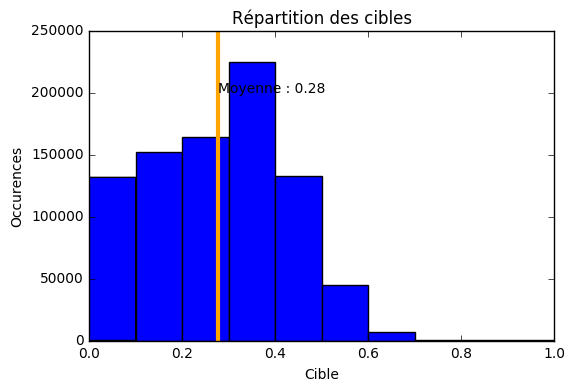

In [4]:
%matplotlib inline
print("Quelques stats essentielles sur le dataset.")
print("Commençons par la variable cible :")
plt.hist(new.label)
plt.title("Répartition des cibles")
plt.xlabel("Cible")
plt.ylabel("Occurences")
mean = new.label.mean()
plt.axvline(mean, color='orange', lw=3)
plt.text(mean, 200000, "Moyenne : {0:.2f}".format(mean))
print("On a donc une cible comprise entre 0 et 1.")
print("Pas d'information sur ce qu'elle représente exactement, \
en dehors de 'l'importance des maladies chroniques', mais on peut supposer que c'est une proba\
ou que les données ont été normalisées.")

Intéressons nous à la fréquences des NAs en % du nombre d'entrées
Les colonnes les plus problématiques :
CI_E4_V2    92.836389
CI_E7_V2    89.742231
CI_DF3      87.257821
CI_DF5      87.257821
CI_DF1      87.257821
dtype: float64


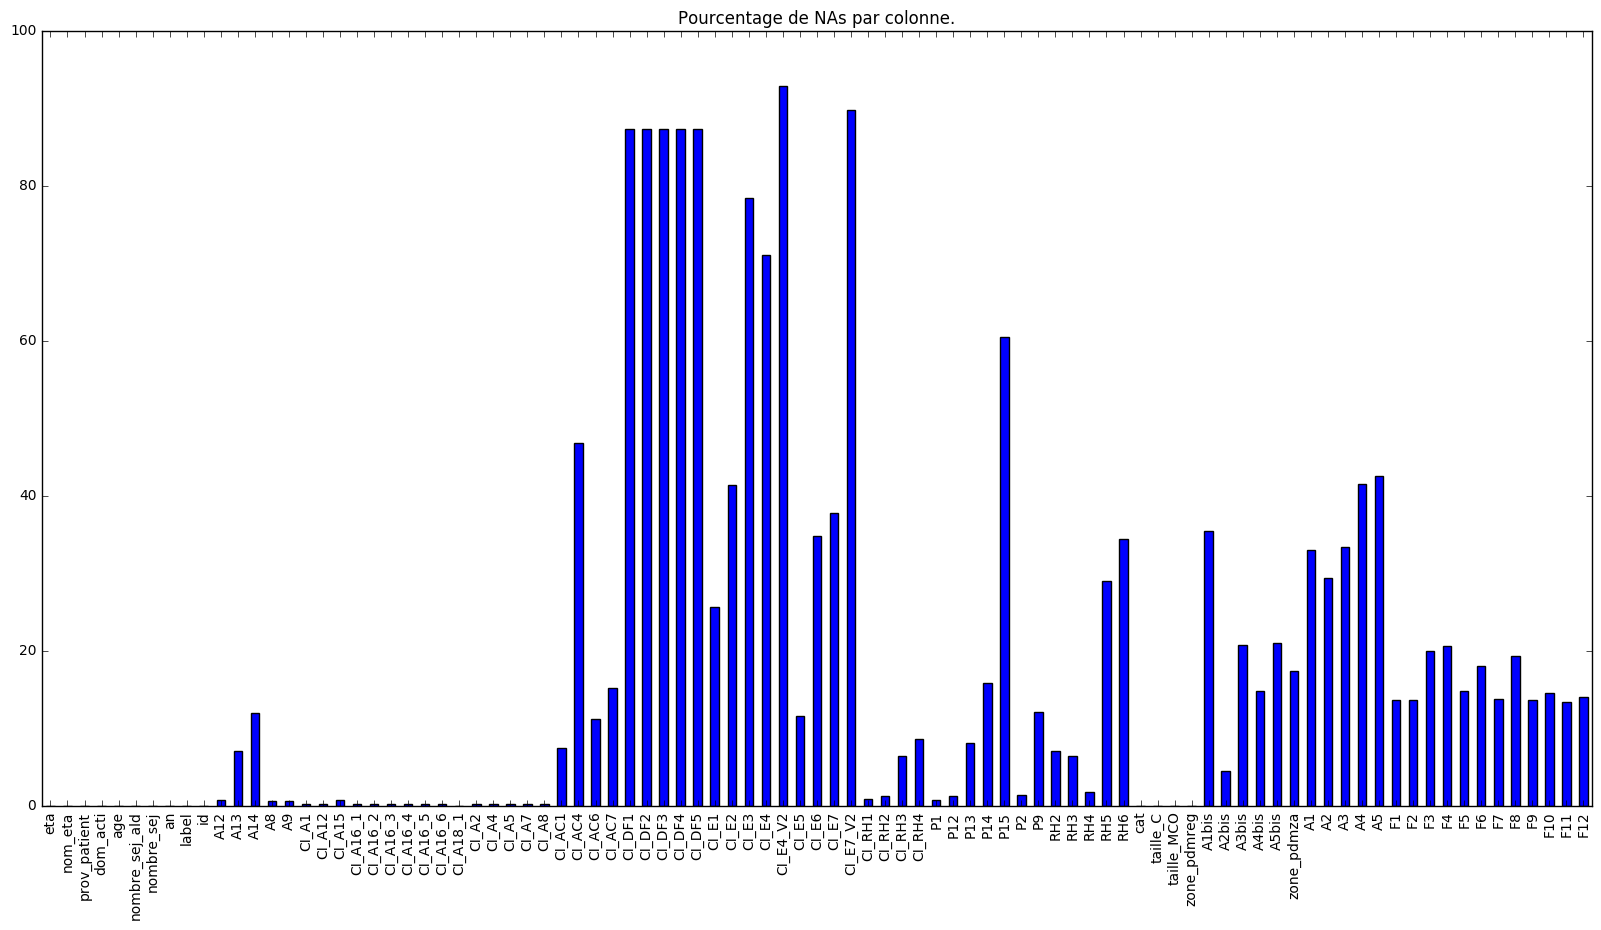

In [5]:
print("Intéressons nous à la fréquences des NAs en % du nombre d'entrées")
new.fillna(-1000, inplace=True)
nacount = new.applymap(lambda col: col == -1000).sum(axis=0)*100/len(new)
print("Les colonnes les plus problématiques :")
print(nacount.sort_values(ascending=False).head(5))
plt.figure(figsize=(20, 10))
plt.title("Pourcentage de NAs par colonne.")
nacount.plot(kind='bar')

## Machine learning : process.py

### Le setup d'apprentissage

Il était difficile d'établir un setup de cross-validation sûr : les données de train étant de 2008 à 2013 et données de test de 2014 à 2015, il était évident qu'on ne devait pas faire un split aléatoire mais par année. 
Cette difficulté a été rencontrée par de nombreux autres participants, comme le montre le nombre anormalement élevé de soumissions : parfois se baser sur le score de cross-val ne suffisait pas pour confirmer des tendances présentes uniquement sur 2014 et 2015. Les scores publics et privés étant remarquablement proches, il était intelligent de se servir de cette ressource.

![Nombre élevé de soumissions](submissions.png)

**Remarque** : L'extraction d'infos du leaderboard public explique aussi le nombre élevé de soumissions.

**Plusieurs setups ont été utilisées :**
    * 3/4 années continues contre 2/1 année restante. cf fonction cv_split dans *helper.py*.
On prévoit 2012 et 2013 à partir des données 2008 à 2011
On prévoit 2008 et 2009 à partir des données 2010 à 2013
Ceci était le plus proche du split train/test, cette approche offrait le résultat les plus fiables.
En pratique, c'est la **méthode que j'ai la plus utilisée**
    * Chaque année contre toutes les années précédentes. cf fonction one_vs_previous dans *helper.py*.
En théorie proche de la méthode de split mais résultats peu efficaces pour les années 2008 à 2011 (pas assez de données des années précédentes) et dans les autres cas cela se réduit à un split de la méthode précédente.
    * One-vs-all : On prévoit chaque année à partir de toutes les autres. cf fonction one_vs_all dans *helper.py*.
Moins proche du split train/test, cette méthode s'est néanmoins révélée la plus utile pour le stacking (voir § ensemblage)

** Une subtilité concernant le score** : Comme énoncé plus tôt, on ne prédit réellement aue les entrées > 0. Cela signifie que notre résultat n'est calculé que sur le *pire* subset des données. Dès lors, notre erreur était plus grande. Comme ~40% des entrées étaient prédictibles parfaitement, on peut dériver mathématiquement (à partir de RMSE) que pour passer du score local au score public, il faut multiplier par $\sqrt{1-0.4} \approx 0.77$.

**Conclusion** : Un problème intrinsèquement difficile à cross-valider qui m'a conduit à tester plusieurs approches sans pouvoir autant faire une confiance aveugle à ma meilleure solution.

### Features critiques

Les features les plus importantes étaient de loin :
* *nombre_sej* : nombre de séjours à l'hôpital du patient
* *nombre_sej_ald* : nombre de séjours à l'hôpital liés à une [ALD](http://www.ameli.fr/professionnels-de-sante/medecins/exercer-au-quotidien/les-affections-de-longue-duree/) i.e pour maladie chronique
Ceci explique pourquoi on a ajouté des features pour ces données et rarement pour les autres. En particulier, on s'est intéressé au rapport des deux qui donnait de très bons résultats, mais aussi à la différence des deux, au log, etc.
En particulier, pourc_ald ($\frac{sej}{sej\_ald}$) et diff_ald ($sej - sej\_ald$) étaient critique (plus de 70% de la feature importance dans le modèle RandomForestRegressor).
XGBoost capte des intéractions plus complexes et voit aussi d'autres variables significatives (cf graph ci-dessous).

![F-score des features pour XGBoost](feature_imp.png)


### Les différents modèles essayés

Les non-linéaritées des données et la présence de variables catégorielles à beaucoup de catégories rendait les méthodes d'arbres particulièrement adaptées.

Voyons rapidement le problème des autres méthodes :
* Régression linéaire/lasso/ridge/etc. : Trop de relations non linéaires, pas de possibilité d'ajouter des variables polynomiales pour les détecter à cause des limites de ram (mais même ces quelques tentatives se sont révélées peu fructueuses).
* Plus proches voisins : Peu efficace, parce que certaines variables étant beaucoup plus critiques que d'autres cela n'a pas de sens d'affecter un poids similaire à toutes dans le calcul des distances. Les méthodes de surpondération des variables critiques ont permi d'améliorer les scores, mais en restant très loin des résultats des méthodes d'arbres.


On a donc utiliser les méthodes d'arbres liées à la régression, en particulier :
*RandomForestRegressor* de sklearn
*GradientBoostingRegressor* de sklearn
*Gradient boosted trees* de xgboost

Au lieu de rentrer dans les détails des nombreuses optimisations, présentons un tableau contenant les principaux résultats :

In [6]:
results = pd.read_csv("resultats resume.csv")
results.head(6)

,Hospidiag,Scaling,Stacking,Algorithme,Score
0,NaN,NaN,N,"Régression linéaire, plus proches voisins, etc.",Plus de 5
1,N,N,N,Random Forest Regressor (RFR),3.66
2,N,N,N,Extra Trees Regressor (ETR),4.55
3,N,N,N,XGBoost (XGB),4.05
4,O,N,N,Random Forest Regressor,2.98
5,O,N,N,XGBoost,2.9


On remarque deux choses intéressantes :

RFR > ETR : C'est normalement le cas quand il n'y a pas trop de bruit à l'échelle de l'ensemble du dataset. En effet, pour construire un arbre, RFR trouve le meilleur split quand ETR trouve le meilleur split parmis une list aléatoire de split candidats. On a donc un cas classique de compromis biais vs variance, où RFR à le meilleur biais. Comme globalement nos données sont proches entre années, RFR a de meilleures performances.

RFR vs XGB : On ne peut pas dire... On verra par la suite ce qui explique que RFR > XGB.

Le parameter-tuning a été fait à la main plutôt que par GridSearch, notamment à cause des temps de calcul.

### L'extraction d'information cruciales via le leaderboard public

Une **astuce critique** pour améliorer son résultat était de **sonder le leaderboard public** pour **récupérer les moyennes annuelles pour la variable cible**. 
Il est d'habitude dangereux de se fonder sur les résultats du leaderboard public pour fine-tuner des algos à cause des risques d'overfitting. 

Cependant, les sources de variance entre les entrées pouvant être résumée en 
1. Variance liée à des patients différents
2. Variance liée à des établissements de santé différents
3. Variance liée à des années différentes
Cette dernière source étant importante, il était important de pouvoir estimer la valeur moyenne de la cible en 2014 et 2015. 

Comparons un modèle naĩf baseline ([TCAM - Taux de croissance annuel moyen](https://fr.wikipedia.org/wiki/Taux_de_croissance#Taux_de_croissance_annuel_moyen)) pour 2014 et 2015 aux "vraies valeurs" extraites.

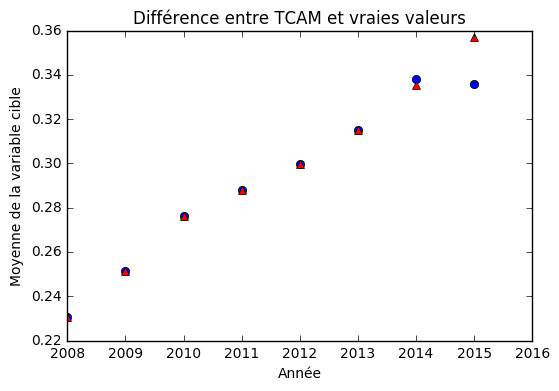

In [7]:
from mini_scaler import average_year
cagr = (average_year[2013]/average_year[2008])**(1/5)
average_year_naive = average_year.copy()
for i in range(1, 3):
    average_year_naive[2013 + i] = average_year[2013]*cagr**i
average_year = pd.Series(average_year)
average_year_naive = pd.Series(average_year_naive)
plt.plot(average_year.index, average_year, 'bo')
plt.plot(average_year_naive.index, average_year_naive, 'r^')
plt.title("Différence entre TCAM et vraies valeurs")
plt.ylabel("Moyenne de la variable cible")#
plt.xlabel("Année")
plt.xlim(2008, 2016)
# On évite la notation scientifique pour l'axe x
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

On voit ainsi que notre **méthode de scaling est beaucoup plus efficace** que la méthode intuitive ou qu'une baseline constante. Elle permet en effet de voir la **baisse anormale en 2015** et de l'intégrer.

Pour sonder le leaderboard, on a scalé nos prédictions par $\alpha$ et utilisé le feedback du leaderboard public par dichotomie pour obtenir l'$\alpha$ optimal et donc la moyenne de la cible par année.
L'image ci-dessous montre bien ce processus de dichotomie, avec des horaires de soumission très rapprochés et des résultats qui fluctuent. La proximité du score public (1ère colonne) et privé montre bien combien cette idée pouvait avoir de la valeur.

![Recherche de moyenne par dichotomie](scaling.png)

Pour des raisons liées aux différences citées ci-dessus, cette astuce apportait des gains beaucoup plus importants pour des RandomForest que pour des méthodes GradientBoosted. Quoiqu'il en soit, on observe que **l'application de cette astuce m'a fait gagner 10% sur mon score** ! 

C'est aussi ici que j'ai compris **pourquoi RFR > XGB** :



In [8]:
results.iloc[[1, 3, 4, 5, 6, 7], :]

,Hospidiag,Scaling,Stacking,Algorithme,Score
1,N,N,N,Random Forest Regressor (RFR),3.66
3,N,N,N,XGBoost (XGB),4.05
4,O,N,N,Random Forest Regressor,2.98
5,O,N,N,XGBoost,2.9
6,O,O,N,Random Forest Regressor,2.65
7,O,O,N,XGBoost,2.85


On observe ici que **RFR > XGB**. En fait, XGBoost capte des intéractions plus subtiles mais au niveau local (parce qu'il entraîne des weak learners qui fonctionnent bien globalement) quand RFR optimise autant que possible au niveau global. Or comme le bruit local est assez fort (sa signification évolue d'année en année), XGB fonctionne moins bien.

E.g XGB > RFR avant scaling parce qu'il est capable d'utiliser les données hospidiag pour inférer la moyenne de l'année. Cependant, il ne peut pas le faire bien parce que cette moyenne ne dépend pas que des données hospidiag (cf changements juridiques; démographiques, ...) et va donc avoir presque la bonne moyenne mais avec beaucoup plus d'erreurs dans ses prédictions individuelles. Dès lors, quand on scale les données avec les vraies valeurs, RFR > XGB.

**Note** : La présence d'un bruit assez fort localement sur certains exemples est visible dans le fait que AdaBoostRegressor (ABR) fonctionne très mal : en accordant de plus en plus de poids aux exemples mal classés, ABR va se concentrer sur les exemples difficile à prédire (et donc ne rien réussir à faire) au lieu d'améliorer son score sur les exemples simples. 

### Le feature engineering

* Assez généralement, le feature engineering qui n'est pas à l'origine d'information fondamentalement nouvelles n'est pas très utiles pour les méthodes d'arbres. Cela a été confirmé par le manque de résultats de la plupart des méthodes de feature engineering (différences de variables, produits de variables, passage au $\log{x_j}$ ou à $\sqrt{x_j}$, indicatrices, etc.).
* J'ai expérimenté assez longtemps avec la création de features bayésiennes inspirées de l'algorithme de naive bayes. En particulier, j'ai essayé : 
    1. Ajouter à chaque entrée la moyenne de la variable cible pour cet établissement (en ignorant les différences liées au nombre de séjours et nombre de séjours en ALD) sur toutes les années (on ne peut pas faire sur une seule année parce que trop d'overfitting et impossible pour les données de test).
    2. Ajouter à chaque entrée la moyenne de la variable cible pour le même nombre de séjours pour cet établissement.
    3. Ajouter un benchmark qui est la moyenne des différentes moyennes pour chaque nombre de séjours.

La méthode 2. conduisait simplement à de l'overfitting. Les méthodes 1 et 3 apportaient des légers gains en cross-validation (~2-3%). Elles ont été utilisées dans certains modèles. Le code est disponible dans les fonctions *naive_bayes, benchmark et compare_to_benchmark* du fichier *helper.py*.
* Bien que les meilleurs participants soient en attente de confirmation officielle des résultats avant de décrire leur solutions, j'ai appris du participant numéro 5 qu'ajouter la feature *nombre d'entrées pour cet établissement* était utile. Dans mon modèle final, ceci m'apportait une amélioration non négligeable de 5%.

### L'ensemblage

Pour améliorer un peu nos résultats, on a utilisé une méthode classique des compétitions de data, le stacking. Le principe est d'utiliser les prévisions de modèles comme features pour d'autres modèles.

On prévoit donc chaque année à partir de toutes les autres (one-vs-all),  pour train et pour test (c'est le niveau 1). Dans un second temps, on utilise un deuxième modèle qu'on entraîne avec les features initiales *et* les prédictions des autres modèles.

Ceci permet d'avoir un méta-modèle qui apprend à combiner au mieux les deux modèles, en détectant les erreurs de calibration de chacun. C'est plus efficace que des moyennes pondérées.

Pour le niveau 1, on a utilisé XGB, ETR, et RFR et pour le niveau 2 on a utilisé un XGB ultra-régularisé (pour l'empêcher de détecter des choses autres que de la calibration) avec une max-depth de 3.

Ceci est utile, parce que nos modèles ne sont pas parfaitement bien calibrés. On prend des scores similaires pour avoir des graphes comparables.

Ainsi pour RFR:

![Graphique de calibration du RFR](calibration_rfr.png)

Et pour XGBoost

![Graphique de calibration du XGB](calibration_xgb.png)

Si on regarde le début où la fin des graphiques de calibration, on voit que les modèles ne sont pas également calibrés (par exemple pour les petites prédictions, les erreurs sont centrées autour des vraies valeurs pour XGB alors qu'elles sont au-dessus pour RFR). On peut exploiter ceci pour gagner encore un peu en score.

Ci-dessous le code utilisé pour générer les graphiques de calibration, non présent dans le github.

In [9]:
def calibration_plot(test, pred, output='calibration.png', model='RFR'):
    test = test.sort_values()
    pred = pred.loc[test.index]
    plt.figure(figsize=(20, 15))
    plt.title('Calibration graph for {}'.format(model))
    plt.ylabel('True value/Value predicted')
    plt.xlabel('Samples (sorted)')
    # 0.77 To compensate for not predicting 0s.
    rmse = mean_squared_error(test, pred)**0.5*100*0.77
    plt.text(10000, 0.97, 'RMSE: {0:.2f}'.format(rmse))
    plt.plot(range(len(pred)), test, 'bo', alpha=1, label='True values')
    plt.plot(range(len(pred)), pred, 'r^', alpha=0.05)
    # Ugly hack to have right alpha in legend
    plt.plot(1, 0, 'r^', alpha=1, label='Predictions')
    plt.legend()
    plt.savefig(output)
    plt.show()

### Récapitulatif des scores

In [10]:
results

,Hospidiag,Scaling,Stacking,Algorithme,Score
0,NaN,NaN,N,"Régression linéaire, plus proches voisins, etc.",Plus de 5
1,N,N,N,Random Forest Regressor (RFR),3.66
2,N,N,N,Extra Trees Regressor (ETR),4.55
3,N,N,N,XGBoost (XGB),4.05
4,O,N,N,Random Forest Regressor,2.98
5,O,N,N,XGBoost,2.9
6,O,O,N,Random Forest Regressor,2.65
7,O,O,N,XGBoost,2.85
8,O,O,O,"1er niveau : ETR, RFR, XGB. 2Ème : XGB",2.54


### Critique de la méthodologie de la compétition

Bien que la compétition soti dans l'ensemble bien orchestrée, quelque chose pose fondamentalement problème :
Les données hospidiag sont des données qui sont reçues à la fin de l'année (comme le montre le fait que pour 2015 la plupart des données ne sont pas présentes, ce qui oblige à avoir deux ensembles différents dans *columns.py*) et ne pourront donc pas être utilisées au cours de l'année pour prédire les valeurs comme on le fait ici.